In [1]:
# As usual, a bit of setup
import time
from time import process_time
import numpy as np
import matplotlib.pyplot as plt
import LOUPE.WILLOW.loupe as lp
import tensorflow as tf
import h5py
import pandas as pd
import csv
import copy
import math
from utils.data_utils import *
import sys
import re
from utils.spj import Config
from utils.spj import SPJ
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


# Training Model

In [17]:
def model(H_train, Ipast_train, Ifuture_train, Ycaptions_train, Xcaptions_train, learning_rate, num_epochs, print_cost = True):
    """
    Implements a tensorflow neural network: C3D->ATTENTION->CAPTIONING
    
    Arguments:
    H_train -- training set, of shape = [n_train,num_c3d_features,num_proposals]
    Y_train -- caption labels, of shape = [n_train,num_proposals,num_steps+1]
    H_test -- training set, of shape = [n_test,num_c3d_features,num_proposals]
    Y_test -- caption labels, of shape = [n_test,num_proposals,num_steps+1]
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    # Directory to Save Checkpoint
    checkpoint_dir = "/home/martnzjulio_a/checkpoints/"
    
    # Reset Graph
    tf.reset_default_graph()    
    
    # For Consistency
    tf.set_random_seed(1)                             
    seed = 3                                         
    
    # Number of Training Examples
    num_train = H_train.shape[0]                        
    
    # to keep track of costs
    costs = []
    
    # Global Epoch Number
    global_step = tf.Variable(0, name='global_step', trainable=False)
    
    # Model
    config = Config()
    spj = SPJ(config)
        
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(spj.loss, global_step=global_step)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()
    
    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
           
        # check for latest checkpoint
        latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
        if latest_checkpoint == None:
            # If no check point run the initialization
            print()
            print("No checkpint exists, initializing parameters...")
            sess.run(init)
        else:
            print()
            print("Restoring from latest checkpoint...")
            saver.restore(sess, latest_checkpoint)
        
        # Training Loop
        print()
        start = process_time() # Record start time
        for epoch in range(num_epochs):
            
            # Variable to store cost
            epoch_loss = 0.0
            
            # Get minibatches
            num_minibatches = num_train // config.batch_size 
            seed = seed + 1
            minibatches = random_mini_batches(H_train, Ipast_train, Ifuture_train, Ycaptions_train, Xcaptions_train, config.batch_size, seed = 0)

            for counter, minibatch in enumerate(minibatches):
                
                # Select minibatch
                (minibatch_H, minibatch_Ipast, minibatch_Ifuture, minibatch_Ycaptions, minibatch_Xcaptions) = minibatch
                
                # Run Session
                _ , minibatch_loss = sess.run([optimizer, spj.loss], feed_dict={spj._H: minibatch_H, spj._Ipast: minibatch_Ipast, spj._Ifuture: minibatch_Ifuture, spj._x: minibatch_Xcaptions, spj._y: minibatch_Ycaptions})
                epoch_loss += minibatch_loss / num_minibatches
                
            # Print cost
            if print_cost == True:
                print ("Loss after epoch %i: %f" % (epoch, epoch_loss))
                costs.append(epoch_loss)
            
            # Save Model (every 20 epochs)
            if epoch % 20 == 0:
                print("Saving Checkpoint for global_step " + str(global_step))
                saver.save(sess, checkpoint_dir + 'model', global_step = global_step)
        
        # Save and Print Processed Time
        end = process_time() 
        print()
        print("Time Elapased: ", end - start)
        print()
        
        # Plot Loss Curve
        final_costs = np.squeeze(costs)
        plt.plot(final_costs)
        plt.ylabel('Loss')
        plt.xlabel('Epochs')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
        return 0

number of examples:  99
train_data.shape:  (590, 508)
padded_proposals.shape:  (99, 500, 30)
padded_framestamps.shape:  (99, 2, 30)
Total number of words in all captions:  504895
Vocabulary Size (Unique):  13001

Restoring from latest checkpoint...
INFO:tensorflow:Restoring parameters from /home/martnzjulio_a/checkpoints/model-33

Loss after epoch 0: 8274.286444
Saving Checkpoint for global_step <tf.Variable 'global_step:0' shape=() dtype=int32_ref>
Loss after epoch 1: 8023.298784
Loss after epoch 2: 7886.095703
Loss after epoch 3: 7813.683327
Loss after epoch 4: 7769.290749

Time Elapased:  36.196556767999994



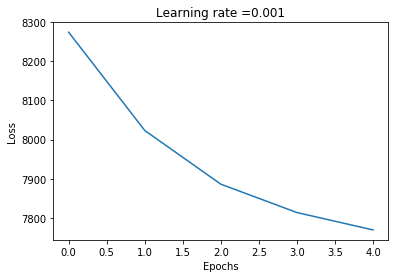

0

In [18]:
# Load Training Data
train_ids,train_data,padded_proposals,padded_framestamps = video_preprocess()

# Get word2id and sentences
embedding_size =512
vocabulary,vocab_size = caption_preprocess()
emb_matrix,word2id,id2word = get_wordvector(embedding_size,vocab_size,vocabulary)
pad_len = 50
all_padded_sentences,all_padded_sentences_2,all_padded_sentences_id = get_padded_sentences_id(pad_len,train_ids, train_data, word2id)     

sentence_ids = all_padded_sentences_id
Ycaptions = copy.deepcopy(all_padded_sentences_2) 
Xcaptions = copy.deepcopy(all_padded_sentences)
Xcaptions = np.transpose(Xcaptions,axes=(0,2,1)).astype(np.int32)
Ycaptions = np.transpose(Ycaptions,axes=(0,2,1)).astype(np.int32)

# Input Features
H = padded_proposals.astype(np.float32)

# Input Framstamps [f_init, f_end]
framestamps = padded_framestamps

# Input Indicators for past and future
Ipast = temporal_indicator(framestamps, mode="past").astype(np.float32)
Ifuture = temporal_indicator(framestamps, mode="future").astype(np.float32)

# Word Embedding Matrix
emb_matrix, word2id, id2word = get_wordvector(embedding_size,vocab_size,vocabulary) #changed by Songze

# Train Model
learning_rate = 0.001
num_epochs = 5
model(H, Ipast, Ifuture, Ycaptions, Xcaptions, learning_rate, num_epochs)